/home/juan/.local/lib/python3.7/site-packages/ipykernel_launcher.py:35: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


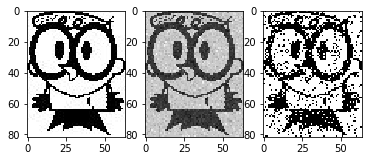

In [424]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import misc
import copy


def add_gaussian_noise(im,prop,varSigma):
    N = int(np.round(np.prod(im.shape)*prop))
    index = np.unravel_index(np.random.permutation(np.prod(im.shape))[1:N],im.shape)
    e = varSigma*np.random.randn(np.prod(im.shape)).reshape(im.shape)
    im2 = np.copy(im).astype('float')
    im2[index] += e[index]
    return im2

def add_saltnpeppar_noise(im,prop):
    N = int(np.round(np.prod(im.shape)*prop)) + 1000
    index = np.unravel_index(np.random.permutation(np.prod(im.shape))[1:N],im.shape)
    im2 = np.copy(im)
    im2[index] = 1-im2[index]
    return im2

def binaryImage(image):
    cp_image = copy.deepcopy(image)
    for x in range(len(cp_image)):
        for y in range(len(cp_image[0])):
            val = round(cp_image[x][y])
            if val == 1:
                cp_image[x][y] = -1
            else:
                cp_image[x][y] = 1
    return cp_image
# proportion of pixels to alter
prop = 0.7
varSigma = 0.1
im = misc.imread('images/dexter.jpg')
im = im/255
#im = binaryImage(im)
fig = plt.figure()
ax = fig.add_subplot(131)
ax.imshow(im,cmap='gray')
im2 = add_gaussian_noise(im,prop,varSigma)
ax2 = fig.add_subplot(132)
ax2.imshow(im2,cmap='gray')
im3 = add_saltnpeppar_noise(im,prop)
im3 = binaryImage(im3)
ax3 = fig.add_subplot(133)
ax3.imshow(im3,cmap='gray')



In [411]:
def neighbours(i,j,M,N,size=4):
    if size==4:
        if (i==0 and j==0):
            n=[(0,1), (1,0)]
        elif i==0 and j==N-1:
            n=[(0,N-2), (1,N-1)]
        elif i==M-1 and j==0:
            n=[(M-1,1), (M-2,0)]
        elif i==M-1 and j==N-1:
            n=[(M-1,N-2), (M-2,N-1)]
        elif i==0:
            n=[(0,j-1), (0,j+1), (1,j)]
        elif i==M-1:
            n=[(M-1,j-1), (M-1,j+1), (M-2,j)]
        elif j==0:
            n=[(i-1,0), (i+1,0), (i,1)]
        elif j==N-1:
            n=[(i-1,N-1), (i+1,N-1), (i,N-2)]
        else:
            n=[(i-1,j), (i+1,j), (i,j-1), (i,j+1)]
        return n
    if size==8:
        print('Not yet implemented\n')
        return -1

In [507]:
def calculateEnergy(latent, noisy, i, j, beta, eta):
    n = neighbours(i, j, latent.shape[0], latent.shape[1])
    result = 0
    for m in n:
        x, y = m
        result += latent[x][y] * latent[i][j]
    result = result*beta + (latent[i][j]*noisy[i][j])
    return result

def ICM(image, beta, eta, runs):
    latentImage = copy.deepcopy(image)
    for n in range(runs):
        for i in range(image.shape[0]):
            for j in range(image.shape[1]):
                latentImage[i][j] = 1
                posEnergy = calculateEnergy(latentImage, image, i, j, beta, eta)
                latentImage[i][j] = -1
                negEnergy = calculateEnergy(latentImage, image, i, j, beta, eta)
                if posEnergy > negEnergy:
                    latentImage[i][j] = 1
                else:
                    latentImage[i][j] = -1
    return latentImage

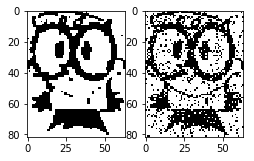

In [454]:
fig = plt.figure()
ax = fig.add_subplot(131)
ax.imshow(ICM(im3, 1, 0.1, 1),cmap='gray')
im2 = add_gaussian_noise(im,prop,varSigma)
ax2 = fig.add_subplot(132)
ax2.imshow(im3,cmap='gray')

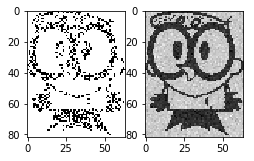

In [511]:
fig = plt.figure()
ax = fig.add_subplot(131)
ax.imshow(ICM(im2, 0, 1, 50),cmap='gray')
im2 = add_gaussian_noise(im,prop,varSigma)
ax2 = fig.add_subplot(132)
ax2.imshow(im2,cmap='gray')